# Stacked autoencoder

It is possible for us to have multiple layers in encoder and
decoder networks; using deeper encoder and decoder networks can allow the autoencoder
to represent complex features. The structure so obtained is called a Stacked Autoencoder
(Deep Autoencoders); the features extracted by one encoder are passed on to the next
encoder as input. The stacked autoencoder can be trained as a whole network with an aim
to minimize the reconstruction error, or each individual encoder/decoder network can be
first pretrained using the unsupervised method you learned earlier, and then the complete
network is fine-tuned. It has been pointed out that, by pretraining, also called Greedy layer-
wise training, the results are better.

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [13]:
mnist = input_data.read_data_sets("MNIST_data/")
trX, trY, teX, teY = mnist.train.images, mnist.train.labels,mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [36]:
class StackedAutoEncoder(object):
    def __init__(self, list1, eta = 0.02):
        """
        list1: [input_dimension, hidden_layer_1, ....,hidden_layer_n]
        """
        N = len(list1)-1
        self._m = list1[0]
        self.learning_rate = eta
        # Create the Computational graph
        self._W = {}
        self._b = {}
        self._X = {}
        self._X['0'] = tf.placeholder('float', [None, list1[0]])
        for i in range(N):
            layer = '{0}'.format(i+1)
            print('AutoEncoder Layer {0}: {1} --> {2}'.format(layer, list1[i], list1[i+1]))
            self._W['E' + layer] = tf.Variable(tf.random_normal(shape=(list1[i],list1[i+1])),name='WtsEncoder'+layer)
            self._b['E'+ layer] =tf.Variable(np.zeros(list1[i+1]).astype(np.float32),name='BiasEncoder'+layer)
            self._X[layer] = tf.placeholder('float', [None, list1[i+1]])
            self._W['D' + layer] = tf.transpose(self._W['E' + layer]) # Shared weights
            self._b['D' + layer] =tf.Variable(np.zeros(list1[i]).astype(np.float32),name='BiasDecoder' +layer)
        # Placeholder for inputs
        self._X_noisy = tf.placeholder('float', [None, self._m])
        self.train_ops = {}
        self.out = {}
        for i in range(N):
            layer = '{0}'.format(i+1)
            prev_layer = '{0}'.format(i)
            opt = self.pretrain(self._X[prev_layer], layer)
            self.train_ops[layer] = opt
            self.out[layer] = self.one_pass(self._X[prev_layer], self._W['E'+layer],
            self._b['E'+layer], self._b['D'+layer])
        self.y = self.encoder(self._X_noisy,N) #Encoder output
        self.r = self.decoder(self.y,N) # Decoder ouput
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        error = self._X['0'] - self.r # Reconstruction Error
        self._loss = tf.reduce_mean(tf.pow(error, 2))
        self._opt = optimizer.minimize(self._loss)
    def fit(self, Xtrain, Xtr_noisy, layers, epochs = 1, batch_size = 100):
        N, D = Xtrain.shape
        num_batches = N // batch_size
        X_noisy = {}
        X = {}
        X_noisy ['0'] = Xtr_noisy
        X['0'] = Xtrain
        print(layers)
        print(num_batches)
        for i in range(layers):
            Xin = X[str(i)]
            print('Pretraining Layer ', i+1)
            #for e in range(5):
            for j in range(num_batches):
                batch = Xin[j * batch_size: (j * batch_size + batch_size)]
                self.session.run(self.train_ops[str(i+1)], feed_dict= {self._X[str(i)]:batch})
                print('Pretraining Finished')
                X[str(i+1)] = self.session.run(self.out[str(i+1)], feed_dict ={self._X[str(i)]: Xin})
                break
        obj = []
        for i in range(epochs):
            for j in range(num_batches):
                batch = Xtrain[j * batch_size: (j * batch_size + batch_size)]
                batch_noisy = Xtr_noisy[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._opt,self._loss], feed_dict={self._X['0']:
                batch, self._X_noisy: batch_noisy})
                if j % 100 == 0 :
                    print('training epoch {0} batch {2} cost {1}'.format(i,ob, j))
                    obj.append(ob)
        return obj
    def encoder(self, X, N):
        x = X
        for i in range(N):
            layer = '{0}'.format(i+1)
            hiddenE = tf.nn.sigmoid(tf.matmul(x, self._W['E'+layer]) +self._b['E'+layer])
            x = hiddenE
        return x
    def decoder(self, X, N):
        x = X
        for i in range(N,0,-1):
            layer = '{0}'.format(i)
            hiddenD = tf.nn.sigmoid(tf.matmul(x, self._W['D'+layer]) +self._b['D'+layer])
            x = hiddenD
        return x
    def set_session(self, session):
        self.session = session
    def reconstruct(self,x, n_layers):
        h = self.encoder(x, n_layers)
        r = self.decoder(h, n_layers)
        return self.session.run(r, feed_dict={self._X['0']: x})
    def pretrain(self, X, layer ):
        y = tf.nn.sigmoid(tf.matmul(X, self._W['E'+layer]) + self._b['E'+layer])
        r =tf.nn.sigmoid(tf.matmul(y, self._W['D'+layer]) + self._b['D'+layer])
        # Objective Function
        error = X - r # Reconstruction Error
        loss = tf.reduce_mean(tf.pow(error, 2))
        opt = tf.train.AdamOptimizer(.001).minimize(loss, var_list =
        [self._W['E'+layer],self._b['E'+layer],self._b['D'+layer]])
        return opt
    def one_pass(self, X, W, b, c):
        h = tf.nn.sigmoid(tf.matmul(X, W) + b)
        return h
    def corruption(x, noise_factor = 0.3): #corruption of the input
        noisy_imgs = x + noise_factor * np.random.randn(*x.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        return noisy_imgs

In [37]:
Xtrain = trX.astype(np.float32)
Xtrain_noisy = corruption(Xtrain).astype(np.float32)
Xtest = teX.astype(np.float32)
Xtest_noisy = corruption(Xtest).astype(np.float32)
_, m = Xtrain.shape
list1 = [m, 500, 50] # List with number of neurons in Each hidden layer, starting from input layer
n_layers = len(list1)-1
autoEncoder = StackedAutoEncoder(list1)
#Initialize all variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    autoEncoder.set_session(sess)
    err = autoEncoder.fit(Xtrain, Xtrain_noisy, n_layers, epochs=30)
    out = autoEncoder.reconstruct(Xtest_noisy[0:100],n_layers)

AutoEncoder Layer 1: 784 --> 500
AutoEncoder Layer 2: 500 --> 50
2
550
Pretraining Layer  1
Pretraining Finished
Pretraining Layer  2
Pretraining Finished
training epoch 0 batch 0 cost 0.4578994810581207
training epoch 0 batch 100 cost 0.159514382481575
training epoch 0 batch 200 cost 0.14832521975040436
training epoch 0 batch 300 cost 0.14327947795391083
training epoch 0 batch 400 cost 0.13512997329235077
training epoch 0 batch 500 cost 0.13352778553962708
training epoch 1 batch 0 cost 0.13413657248020172
training epoch 1 batch 100 cost 0.12271256744861603
training epoch 1 batch 200 cost 0.12134775519371033
training epoch 1 batch 300 cost 0.12061034142971039
training epoch 1 batch 400 cost 0.11680866032838821
training epoch 1 batch 500 cost 0.11957402527332306
training epoch 2 batch 0 cost 0.12010551244020462
training epoch 2 batch 100 cost 0.11243011057376862
training epoch 2 batch 200 cost 0.11200409382581711
training epoch 2 batch 300 cost 0.11473926901817322
training epoch 2 batch

training epoch 25 batch 500 cost 0.06681913137435913
training epoch 26 batch 0 cost 0.0676017552614212
training epoch 26 batch 100 cost 0.06055339425802231
training epoch 26 batch 200 cost 0.061649978160858154
training epoch 26 batch 300 cost 0.06612024456262589
training epoch 26 batch 400 cost 0.06317875534296036
training epoch 26 batch 500 cost 0.06733141839504242
training epoch 27 batch 0 cost 0.06800343096256256
training epoch 27 batch 100 cost 0.06163874268531799
training epoch 27 batch 200 cost 0.06168209761381149
training epoch 27 batch 300 cost 0.06684163957834244
training epoch 27 batch 400 cost 0.06336353719234467
training epoch 27 batch 500 cost 0.06682352721691132
training epoch 28 batch 0 cost 0.06875263154506683
training epoch 28 batch 100 cost 0.06261051446199417
training epoch 28 batch 200 cost 0.06327954679727554
training epoch 28 batch 300 cost 0.06749488413333893
training epoch 28 batch 400 cost 0.06337934732437134
training epoch 28 batch 500 cost 0.06712472438812256

Text(0, 0.5, 'Fine Tuning Reconstruction Error')

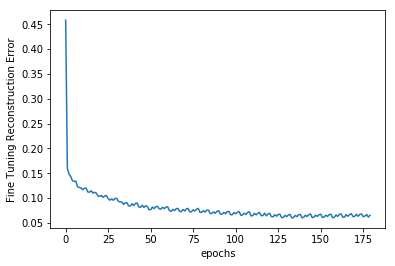

In [38]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Fine Tuning Reconstruction Error')

In [41]:
sess.close()